# Machine Learning with Two Hearts
### Cassandra Overney and Khang Vu

This notebook contains our work for a DrivenData competition, [Machine Learning with a Heart](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/page/109/), which strives to use data science to detect heart disease, the number one cause of death worldwide. The task is to predict the presence or absence of heart disease given various data about a patient, such as resting blood pressure, maximum heart rate, EKG readings, sex, and age.

## Overview of Data

The data comes from the Statlog Heart dataset, which is part of the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/statlog+(heart)). The terms of use are [here](http://archive.ics.uci.edu/ml/citation_policy.html). The UCI Machine Learning Repository contains a collection of datasets that are used by the machine learning community to analyze machine learning algorithms. The datasets in this repository are open to the public. According to the citation policy, we need to include a citation when publishing material based on their data (reference resources section).

We hope to use the heart data to attempt various machine learning algorithms to see which ones have the highest accuracy. We  first [downloaded](https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/data/) the data. There are four data files:
- Training Values: contains data for 13 features and is used to train the models with patients making up the rows and features making up the columns.
- Training Labels: contains the output (0 for no heart disease and 1 for heart disease) for the patients in Training Values.    
- Test Values: same structure as Training Values but with different patients. This data is used to make predictions after training the model.
- Submission Format: same structure as Training Labels but without the `heart_disease_present` data. We will need to fill up that column to be scored. 

The 13 features include:
- `slope_of_peak_exercise_st_segment` (type: `int`): the slope of the peak exercise [ST segment](https://en.wikipedia.org/wiki/ST_segment), an electrocardiography read out indicating quality of blood flow to the heart
- `thal` (type: `categorical`): results of [thallium stress test](https://www.ucsfbenioffchildrens.org/tests/007201.html) measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect
- `resting_blood_pressure` (type: `int`): resting blood pressure
- `chest_pain_type` (type: `int`): chest pain type (4 values)
- `num_major_vessels` (type: `int`): number of major vessels (0-3) colored by flourosopy
- `fasting_blood_sugar_gt_120_mg_per_dl` (type: `binary`): fasting blood sugar > 120 mg/dl
- `resting_ekg_results` (type: `int`): resting electrocardiographic results (values 0,1,2)
- `serum_cholesterol_mg_per_dl` (type: `int`): serum cholestoral in mg/dl
- `oldpeak_eq_st_depression` (type: `float`): oldpeak = [ST depression](https://en.wikipedia.org/wiki/ST_depression) induced by exercise relative to rest, a measure of abnormality in electrocardiograms
- `sex` (type: `binary`): 0: female, 1: male
- `age` (type: `int`): age in years
- `max_heart_rate_achieved` (type: `int`): maximum heart rate achieved (beats per minute)
- `exercise_induced_angina` (type: `binary`): exercise-induced chest pain (0: False, 1: True)

## Data Cleaning
Before running any analysis, we need to read in the data and replace the values of `thal` with numerical values.

In [1]:
import pandas as pd
import numpy as np
import thinkstats2
import thinkplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
import statsmodels.formula.api as smf

from sklearn.linear_model import Ridge, LogisticRegression, Lasso, RidgeClassifier, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score

# pip install --upgrade tensorflow
# pip install --upgrade keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, regularizers

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train_values = pd.read_csv('data/train_values.csv')
train_labels = pd.read_csv('data/train_labels.csv')
train = pd.merge(train_values, train_labels, on="patient_id")

Set index to `patient_id`

In [3]:
train = train.set_index('patient_id')
train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


Replace `thal` values with numbers. 
- `normal`: 0
- `fixed_defect`: 1
- `reversible_defect`: 2

In [4]:
train['thal'] = train['thal'].replace('normal', 0)
train['thal'] = train['thal'].replace('fixed_defect', 1)
train['thal'] = train['thal'].replace('reversible_defect', 2)
train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,0,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,0,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,0,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,2,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,2,178,1,0,0,2,270,4.2,1,59,145,0,0


## Exploratory Data Analysis

An important part of data science is to have a thorough understanding of the data you are working with. To learn about the 13 different features, we decided to study their distributions. In this section, we create histograms for categorical variables with and without heart disease presence, probability mass functions (PMFs) and cumulative distribution functions (CDFs) for quantitative variables with and without heart disease presence, and scatter plots comparing the quantitative variables.    

### Response Variable
Plot the distribution of `heart_disease_present`

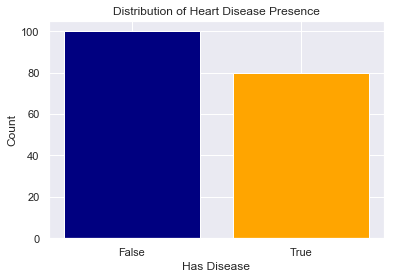

In [5]:
data = train['heart_disease_present'].value_counts().values
title='Distribution of Heart Disease Presence'
bars = ('False', 'True')
y_pos = np.arange(len(bars))
plt.bar(y_pos, data, color=['navy', 'orange'])
plt.xticks(y_pos, bars)
plt.title(title)
plt.xlabel('Has Disease')
plt.ylabel('Count')
plt.show()

The data is pretty well-balanced, so we don't need to take any steps to equalize the classes when we train our models.

### Histograms

Plot the categorical variables with histograms. We also include quantitative variables with less than 4 unique values.

We create the `bar_names` dictionary to store any special x-axis labels. 

In [6]:
histo_vars = ['thal', 'exercise_induced_angina', 'chest_pain_type', 'num_major_vessels', 'slope_of_peak_exercise_st_segment', 'sex', 'resting_ekg_results', 'fasting_blood_sugar_gt_120_mg_per_dl']
bar_names = {}
bar_names['thal'] = ['', 'normal', 'fixed_defect', 'reversible_defect', '']
bar_names['fasting_blood_sugar_gt_120_mg_per_dl'] = ['', 'False', 'True', '']
bar_names['sex'] = ['', 'Female', 'Male', '']
bar_names['exercise_induced_angina'] = ['', 'False', 'True', '']

`plot_histogram` is a plotting function that creates a bar graph with only integer values on the x-axis.

In [7]:
def plot_histogram(x_axes, ax, df, var, title=''):
    # Be sure to only pick integer tick locations.
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
    data = df[var]
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    bins = np.arange(left_of_first_bin, right_of_last_bin + d, d)
    ax.hist(data, bins)
    ax.set(xlabel=var, ylabel='Count')
    try:
        x_axes[var] = ax.get_xticks()
        ax.set_xticklabels(bar_names[var])
    except:
        x_axes[var] = ax.get_xticks()
    if title:
        ax.set(title=title)
    ax.xaxis.labelpad = 10
    return x_axes

Call `plot_histogram` on each variable in `histo_vars`.

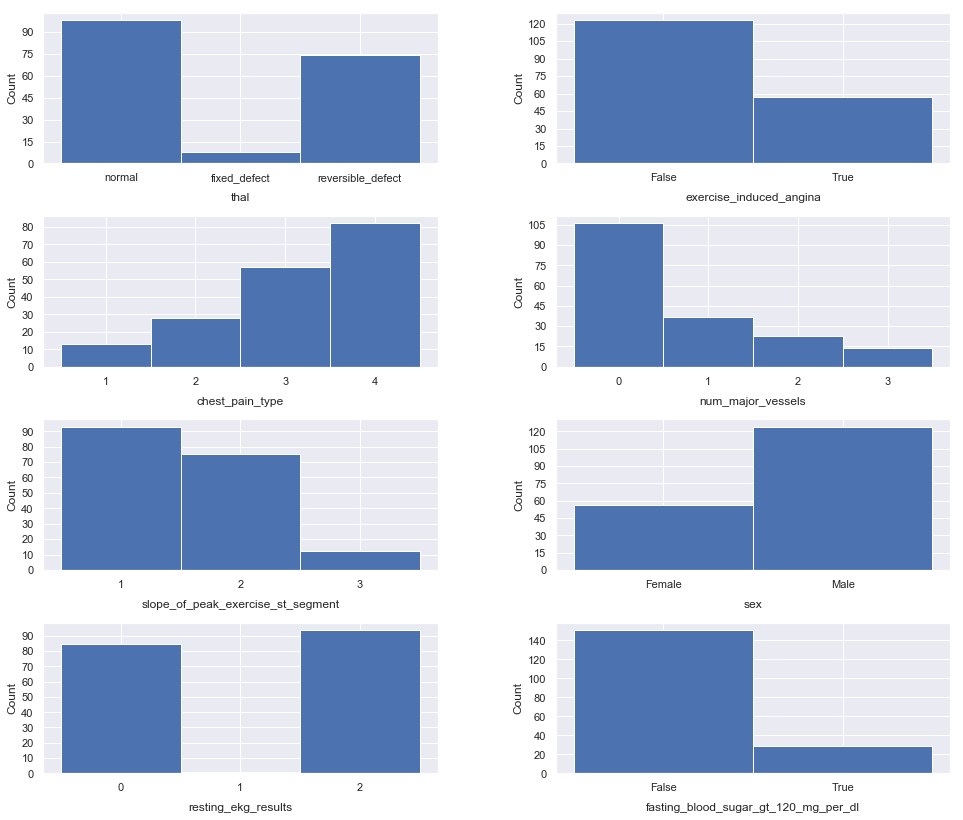

In [8]:
fig, axarr = plt.subplots(4, 2, figsize=(14,12))
x_axes = {}
counter = 0
for i in range(4):
    for j in range(2):
        x_axes = plot_histogram(x_axes=x_axes, ax=axarr[i, j], df=train, var=histo_vars[counter])
        counter += 1
plt.subplots_adjust(bottom=0, left=0, wspace=0.3, hspace=0.35)

None of the histogram distributions appear symmetrical or well balanced. `chest_pain_type` is skewed to the left, while `num_major_vessels` and `slope_of_peak_exercise_st_segment` are skewed to the right. For `thal`, `fixed_defect` has much less counts compared to `normal` and `reversible_defect`, which is a good sign since the values determine how well blood flows into the heart muscle. `exercise_induced_angina` shows that there are less instances of exercise-induced chest pain. Our dataset also has around twice as many men than women.  

### PMFs and CDFs

Plot the distributions of the quantitative variables with PMFs and CDFs.

In [9]:
pmf_vars = ['oldpeak_eq_st_depression', 'max_heart_rate_achieved', 'age', 'serum_cholesterol_mg_per_dl', 'resting_blood_pressure']

For each variable in `pmf_vars`, plot its PMF and CDF. 

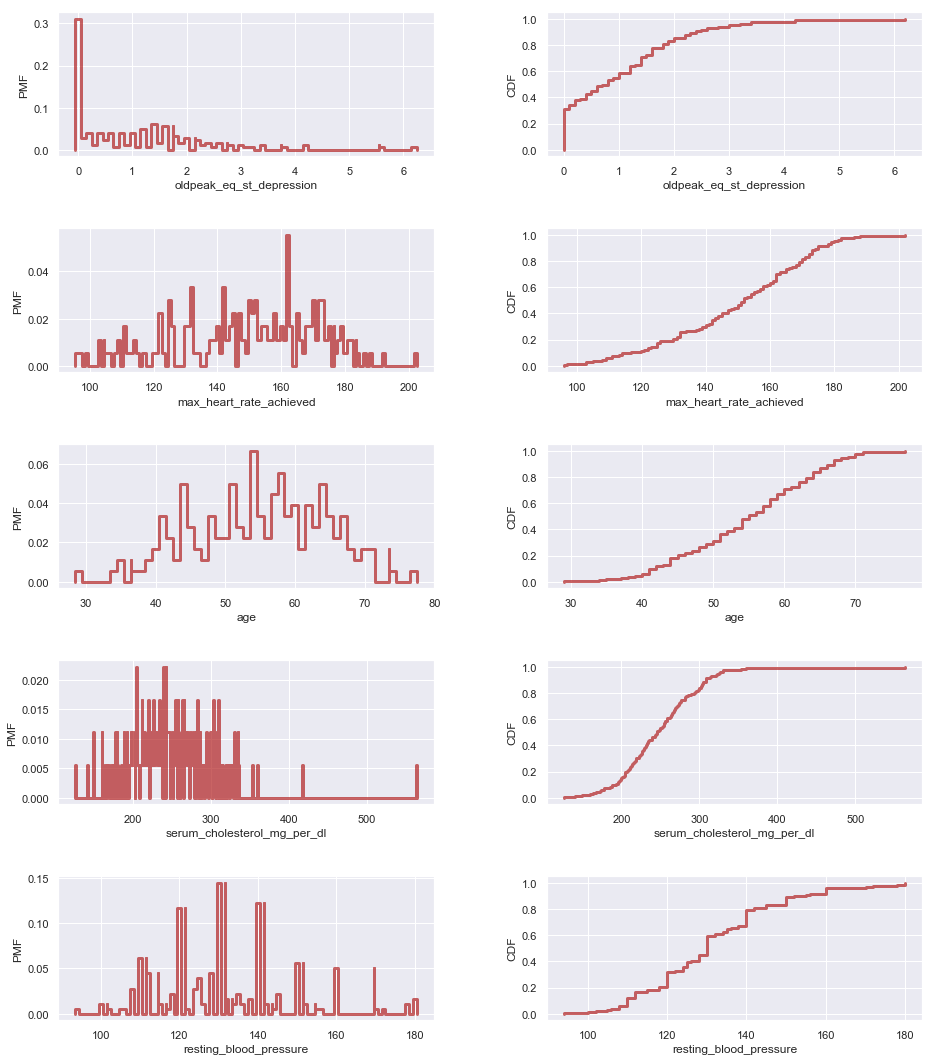

<Figure size 576x432 with 0 Axes>

In [10]:
thinkplot.Figure(figsize=(12, 14))

thinkplot.PrePlot(num=1, rows=5, cols=2)

for i in range(1, 11):
    thinkplot.SubPlot(i, label=str(i))
    counter = int((i-1)/2)
    var = pmf_vars[counter]
    
    if (i-1)%2 == 0:
        pmf = thinkstats2.Pmf(train[var])
        thinkplot.Pmf(pmf, color='firebrick')
        thinkplot.Config(xlabel=var, ylabel='PMF')
    else: 
        # Plot CDF
        cdf = thinkstats2.Cdf(train[var])
        thinkplot.Cdf(cdf, color='firebrick')
        thinkplot.Config(xlabel=var, ylabel='CDF')
        
thinkplot.tight_layout(wspace=0.3, hspace=0.5)
thinkplot.Show()

`oldpeak_eq_st_depression` is highly skewed to the right with the tallest peak occurring at 0. `serum_cholesterol_mg_per_dl` is also skewed to the right. The other three variables look more symmetrical. The distributions contain a lot of oscillations, which are potentially due to rounding and discrete values.       

### Histograms with Heart Disease Groups

We plot histogram distributions for the presence of heart disease groups. First, we split `train` into the has heart disease and doesn't have heart disease groups.

In [11]:
heart_disease = train[train['heart_disease_present']==1]
no_heart_disease = train[train['heart_disease_present']==0]

For each variable in `histo_vars`, plot histogram with `heart_disease` and `no_heart_disease` groups. 

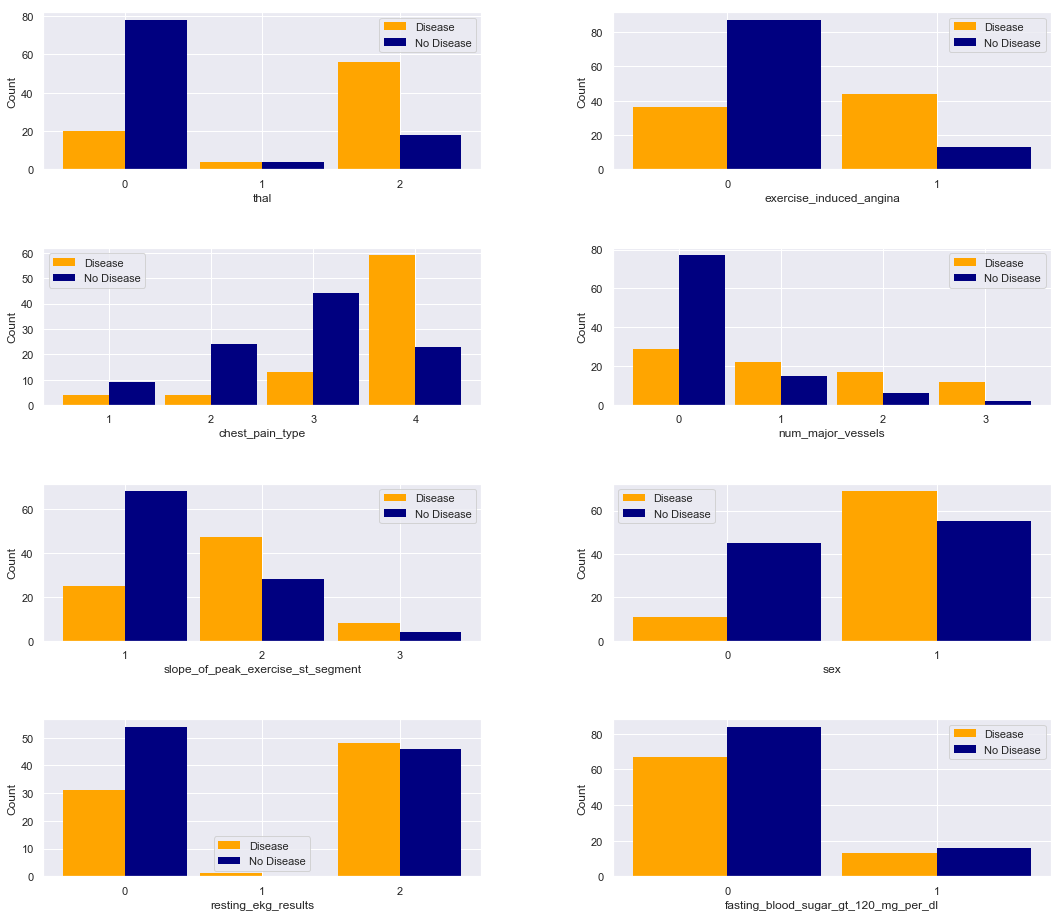

<Figure size 576x432 with 0 Axes>

In [12]:
thinkplot.Figure(figsize=(14, 12))

thinkplot.PrePlot(num=2, rows=4, cols=2)

width = 0.45

for i in range(1, 9):
    thinkplot.SubPlot(i, label=str(i))
    counter = i-1
    var = histo_vars[counter]
    heart_disease_hist = thinkstats2.Hist(heart_disease[var], label='Disease')
    no_heart_disease_hist = thinkstats2.Hist(no_heart_disease[var], label='No Disease')
    thinkplot.Hist(heart_disease_hist, align='right', width=width, color='orange', alpha=1)
    thinkplot.Hist(no_heart_disease_hist, align='left', width=width, color='navy', alpha=1)
    x_ticks = x_axes[var][1:-1]
    thinkplot.Config(xlabel=var, ylabel='Count', xticks=x_ticks)
    
thinkplot.tight_layout(bottom=0, left=0, wspace=0.3, hspace=0.5)
thinkplot.Show()

`thal` has some clear differences between the presence of heart disease groups. 0 has a higher count for the non disease group, while 2 is higher for the disease group. In `exercise_induced_angina`, no exercise-induced chest pain is more common in the non disease group. For `chest_pain_type`, the disease group with chest pain type 4 has the highest frequency. For `num_major_vessels`, the non disease group with 0 major vessels has the highest frequency. On the other hand, the differences between the presence of heart disease groups are not as large for `fasting_blood_sugar_gt_120_mg_per_dl` and `resting_ekg_results`.    

### PMFs and CDFs with Heart Disease Groups

We plot PMF and CDF distributions for presence of heart disease groups.

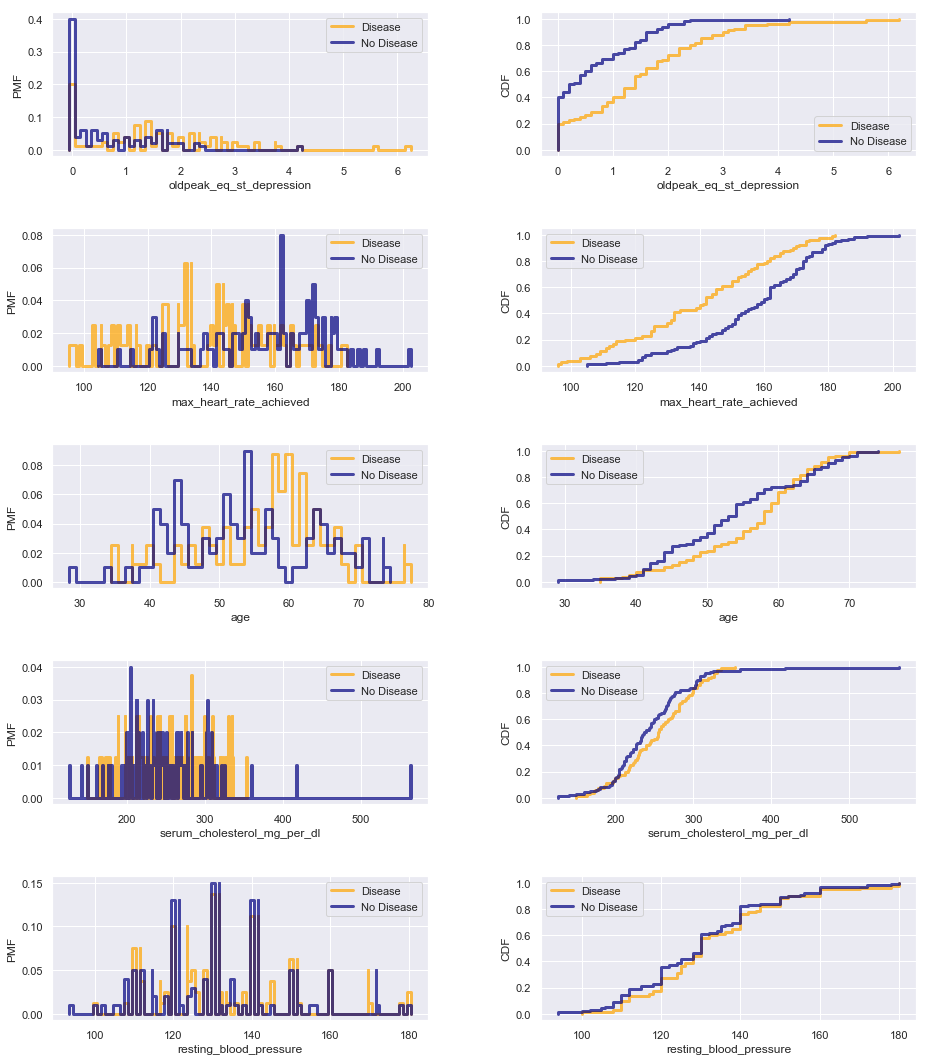

<Figure size 576x432 with 0 Axes>

In [13]:
thinkplot.Figure(figsize=(12, 14))

thinkplot.PrePlot(num=2, rows=5, cols=2)

for i in range(1, 11):
    thinkplot.SubPlot(i, label=str(i))
    counter = int((i-1)/2)
    var = pmf_vars[counter]
    
    if (i-1)%2 == 0:
        pmf_disease = thinkstats2.Pmf(heart_disease[var], label='Disease')
        pmf_no_disease = thinkstats2.Pmf(no_heart_disease[var], label='No Disease')
        thinkplot.Pmf(pmf_disease, color='orange')
        thinkplot.Pmf(pmf_no_disease, color='navy')
        thinkplot.Config(xlabel=var, ylabel='PMF')
    else: 
        # Plot CDF
        cdf_disease = thinkstats2.Cdf(heart_disease[var], label='Disease')
        cdf_no_disease = thinkstats2.Cdf(no_heart_disease[var], label='No Disease')
        thinkplot.Cdf(cdf_disease, color='orange')
        thinkplot.Cdf(cdf_no_disease, color='navy')
        thinkplot.Config(xlabel=var, ylabel='CDF')
        
thinkplot.tight_layout(wspace=0.3, hspace=0.5)
thinkplot.Show()

`oldpeak_eq_st_depression` and `max_heart_rate_achieved` have the largest differences between the presence of heart disease groups. In `oldpeak_eq_st_depression`, the non disease group has a higher peak at 0. In `max_heart_rate_achieved`, the presence of heart disease groups are shifted apart with disease peaking at around 130 and non disease peaking at around 160. In contrast, the CDFs for the two groups almost overlap in `age`, `serum_cholesterol_mg_per_dl`, and `resting_blood_pressure`. 

### Scatter Plots
We plot the relationships between the quantitative variables with presence of heart disease groups. After making scatter plots of all permutations of `pmf_vars`, we select the following scatter plots to highlight.

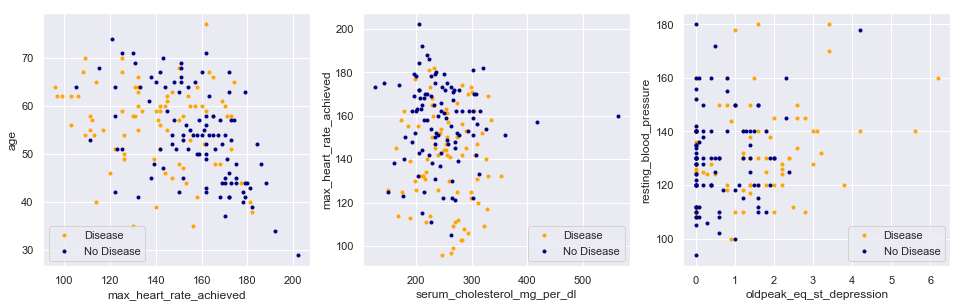

In [14]:
fig, axarr = plt.subplots(1, 3, figsize=(14, 4))
y_vars = ['age', 'max_heart_rate_achieved', 'resting_blood_pressure']
x_vars = ['max_heart_rate_achieved', 'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression']

for index, x_var in enumerate(x_vars):
    ax = axarr[index]
    y_var = y_vars[index]
    x_disease, y_disease = heart_disease[x_var], heart_disease[y_var]
    ax.plot(x_disease, y_disease, '.', alpha=1, label='Disease', color='orange')
    x_no_disease, y_no_disease = no_heart_disease[x_var], no_heart_disease[y_var]
    ax.plot(x_no_disease, y_no_disease, '.', alpha=1, label='No Disease', color='navy')
    if index > 0:
        ax.legend(loc='lower right')
    else:
        ax.legend(loc='best')
    ax.set(xlabel=x_var, ylabel=y_var)

plt.subplots_adjust(bottom=0, left=0, wspace=0.2)

The figure on the left plots `age` against `max_heart_rate_achieved`. The presence of heart disease groups are not completely overlapping each other. The disease cluster tends to have higher ages and lower maximum heart rates, while the non disease cluster tends to have lower ages and higher maximum heart rates.

The figure in the middle plots `max_heart_rate_achieved` against `serum_cholesterol_mg_per_dl`. The presence of heart disease groups have a very high overlap.      

The figure on the right plots `resting_blood_pressure` against `oldpeak_eq_st_depression`. There are a lot of points forming a vertical line with an oldpeak = ST depression value of 0, resulting in a zero inflated distribution. This observation agrees with the PMFs and CDFs above. We will deal with zero inflation below.  

We can deal with the zero inflation in `oldpeak_eq_st_depression` by creating a binary variable `nonzero_oldpeak`. We select for the non zero old peak values. 

In [15]:
nonzero_oldpeak = train[train['oldpeak_eq_st_depression'] > 0].copy()
no_oldpeak = train[train['oldpeak_eq_st_depression'] == 0].copy()

nonzero_oldpeak['nonzero_oldpeak'] = 1
no_oldpeak['nonzero_oldpeak'] = 0

no_oldpeak['oldpeak_eq_st_depression'] = np.nan

frames = [nonzero_oldpeak, no_oldpeak]
train_new = pd.concat(frames)
# Make sure heart_disease_present column is at end of df
heart = train_new.pop('heart_disease_present')
train_new['heart_disease_present'] = heart

Plot `nonzero_oldpeak` with and without heart disease presence groups. 

In [16]:
heart_disease = train_new[train_new['heart_disease_present']==1]
no_heart_disease = train_new[train_new['heart_disease_present']==0]

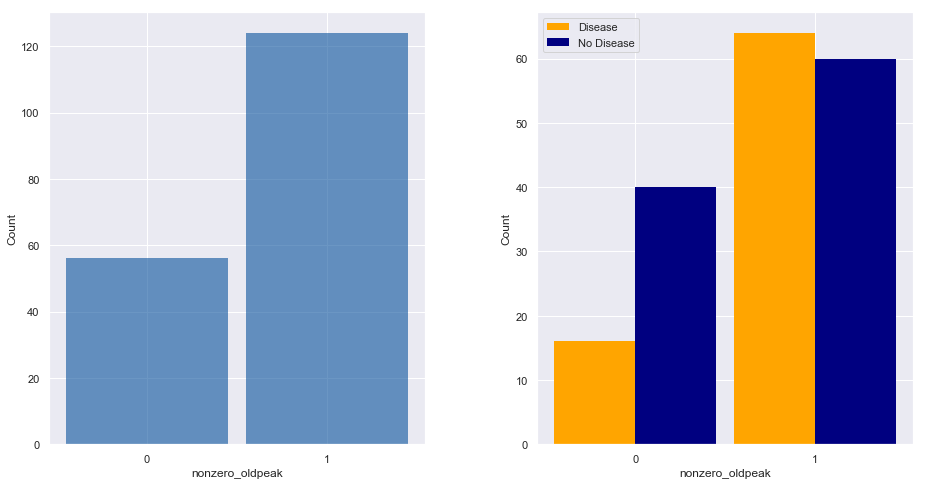

<Figure size 576x432 with 0 Axes>

In [17]:
thinkplot.Figure(figsize=(6, 4))

thinkplot.PrePlot(num=2, rows=1, cols=2)

width = 0.45

var = 'nonzero_oldpeak'

for i in range(1, 3):
    thinkplot.SubPlot(i, label=str(i))
    if i == 1:
        hist = thinkstats2.Hist(train_new[var])
        thinkplot.Hist(hist)
        thinkplot.Config(xlabel=var, ylabel='Count', xticks=[0, 1])
    else:
        heart_disease_hist = thinkstats2.Hist(heart_disease[var], label='Disease')
        no_heart_disease_hist = thinkstats2.Hist(no_heart_disease[var], label='No Disease')
        thinkplot.Hist(heart_disease_hist, align='right', width=width, color='orange', alpha=1)
        thinkplot.Hist(no_heart_disease_hist, align='left', width=width, color='navy', alpha=1)
        thinkplot.Config(xlabel=var, ylabel='Count', xticks=[0, 1])
    
thinkplot.tight_layout(bottom=0, left=0, wspace=0.3)
thinkplot.Show()

There are around twice as many patients with non zero oldpeak = ST depression values. The non disease group has a higher frequency of zero values compared to the disease group. The two groups have similar frequencies for non zero values.

Plot the updated `oldpeak_eq_st_depression` with and without heart disease presence groups.

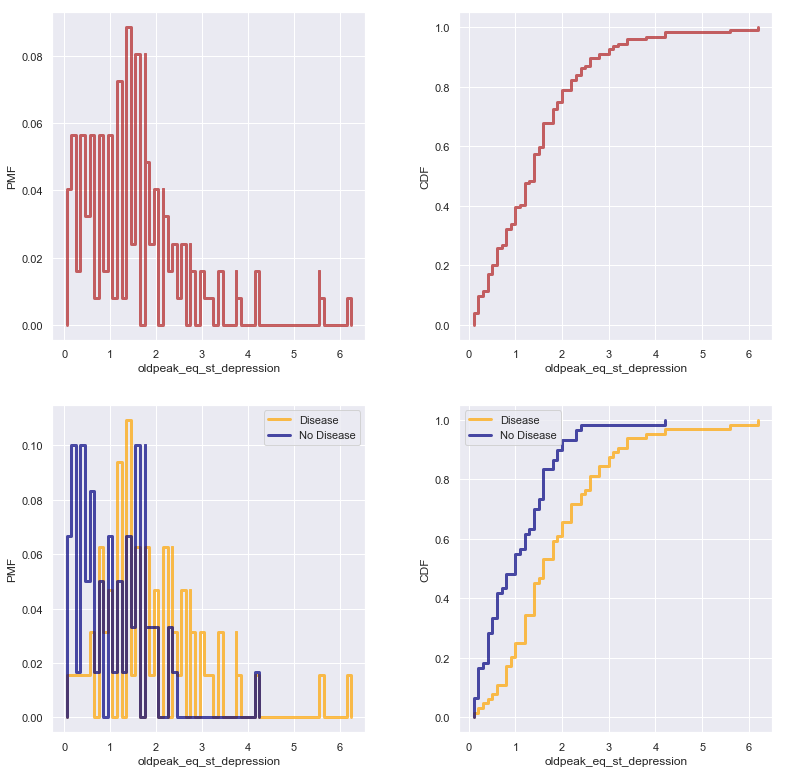

<Figure size 576x432 with 0 Axes>

In [18]:
thinkplot.Figure(figsize=(6, 4))

thinkplot.PrePlot(num=2, rows=2, cols=2)

var = 'oldpeak_eq_st_depression'

for i in range(1, 5):
    thinkplot.SubPlot(i, label=str(i))
    
    if (i-1)%2 == 0:
        if int((i-1)/2) == 0:
            pmf = thinkstats2.Pmf(train_new[var])
            thinkplot.Pmf(pmf, color='firebrick')
        else:
            pmf_disease = thinkstats2.Pmf(heart_disease[var], label='Disease')
            pmf_no_disease = thinkstats2.Pmf(no_heart_disease[var], label='No Disease')
            thinkplot.Pmf(pmf_disease, color='orange')
            thinkplot.Pmf(pmf_no_disease, color='navy')
        thinkplot.Config(xlabel=var, ylabel='PMF')
    else:
        if int((i-1)/2) == 0:
            cdf = thinkstats2.Cdf(train_new[var])
            thinkplot.Cdf(cdf, color='firebrick')
        else:
            cdf_disease = thinkstats2.Cdf(heart_disease[var], label='Disease')
            cdf_no_disease = thinkstats2.Cdf(no_heart_disease[var], label='No Disease')
            thinkplot.Cdf(cdf_disease, color='orange')
            thinkplot.Cdf(cdf_no_disease, color='navy')
        thinkplot.Config(xlabel=var, ylabel='CDF')
        
thinkplot.tight_layout(wspace=0.3, hspace=0.2)
thinkplot.Show()

The distribution of `oldpeak_eq_st_depression` is still skewed to the right but not as much. The peak occurs between 1 and 2. The distribution for the disease group is similar to the overall distribution, while the distribution for the non disease group is bimodal with one peak between 0 and 1 and another peak between 1.5 and 2. 

In [19]:
train_new['oldpeak_eq_st_depression'].replace(np.nan, 0, inplace=True)

## Predictive Power of Each Feature
We conduct simple logistic regression with `heart_disease_present` as the dependent variable and each feature as the explanatory variable. Running 13 to 14 simple logistic regressions allows us to see which explanatory variables can better predict the presence of heart disease. For each variable, we construct a model, compute R-squared, and append the results to a list. The higher the R-squared value, the more predictive power the corresponding variable has.

We first do this without `nonzero_oldpeak` and then include it. 

### Without `nonzero_oldpeak`

In [20]:
categorical = ['thal', 'fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina']
t = []
for var in train.columns[:-1]:
    if var in categorical:
        formula = 'heart_disease_present ~ C(' + var + ')'
    else:
        formula = 'heart_disease_present ~ ' + var
    model = smf.logit(formula, data=train)
    results = model.fit(disp=False)

    t.append((results.prsquared, var))

In [21]:
t.sort(reverse=True)
for r2, name in t:
    print(name, r2)

thal 0.22211008393065912
exercise_induced_angina 0.1511475402871607
chest_pain_type 0.139629233886855
num_major_vessels 0.13770831838862385
oldpeak_eq_st_depression 0.11826930354836762
max_heart_rate_achieved 0.10797913151601879
slope_of_peak_exercise_st_segment 0.08923273120799136
sex 0.08695140221676123
resting_ekg_results 0.01557709847553046
age 0.01405026817582622
serum_cholesterol_mg_per_dl 0.004642434414665164
resting_blood_pressure 0.00448456503608341
fasting_blood_sugar_gt_120_mg_per_dl 8.306880368347258e-06


The variables that affect `heart_disease_present` the most are `thal`, `exercise_induced_angina`, and `chest_pain_type`. `thal` has a predictive power of around 22.2%; `exercise_induced_angina` has a predictive power of around 15.1%, and `chest_pain_type` has a predictive power of around 14.0%. For future comparison, we point out that `oldpeak_eq_st_depression` has a predictive power of around 11.8%.  

### With `nonzero_oldpeak`

In [22]:
categorical = ['thal', 'fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina', 'nonzero_oldpeak']
t = []
for var in train_new.columns[:-1]:
    if var in categorical:
        formula = 'heart_disease_present ~ C(' + var + ')'
    else:
        formula = 'heart_disease_present ~ ' + var
    model = smf.logit(formula, data=train_new)
    results = model.fit(disp=False)

    t.append((results.prsquared, var))

In [23]:
t.sort(reverse=True)
for r2, name in t:
    print(name, r2)

thal 0.22211008393065912
exercise_induced_angina 0.15114754028716104
chest_pain_type 0.13962923388685478
num_major_vessels 0.13770831838862385
oldpeak_eq_st_depression 0.11826930354836762
max_heart_rate_achieved 0.10797913151601868
slope_of_peak_exercise_st_segment 0.08923273120799147
sex 0.08695140221676123
nonzero_oldpeak 0.03448570498068548
resting_ekg_results 0.015577098475530349
age 0.014050268175825997
serum_cholesterol_mg_per_dl 0.004642434414665164
resting_blood_pressure 0.00448456503608341
fasting_blood_sugar_gt_120_mg_per_dl 8.306880368125213e-06


The variables that affect `heart_disease_present` the most are still `thal`, `exercise_induced_angina`, and `chest_pain_type` with the same predictive powers. However, the predictive power of `oldpeak_eq_st_depression` increases from 11.8% to 12.4%. `nonzero_oldpeak` has a predictive power of around 3.4%. The increase in `oldpeak_eq_st_depression`’s predictive power indicates that creating `nonzero_oldpeak` might help with logistic regression, which we will do in the next section.   

We can run logistic regression with all of the variables together. First we create the formula.

In [24]:
categorical = ['thal', 'fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina', 'nonzero_oldpeak']
t = []
formula = ''
for ind, var in enumerate(train_new.columns[:-1]):
    if var in categorical:
        if ind == 0:
            formula = 'heart_disease_present ~ C(' + var + ')'
        else:
            formula += '+ C(' + var + ')'
    else:
        if ind == 0:
            formula = 'heart_disease_present ~ ' + var
        else:
            formula += '+' + var

In [25]:
model = smf.logit(formula, data=train_new)
results = model.fit(disp=False)
results.params

Intercept                                      -5.076341
C(thal)[T.1]                                    0.177187
C(thal)[T.2]                                    1.533481
C(fasting_blood_sugar_gt_120_mg_per_dl)[T.1]   -0.401163
C(sex)[T.1]                                     1.452573
C(exercise_induced_angina)[T.1]                 1.003064
C(nonzero_oldpeak)[T.1]                        -1.480063
slope_of_peak_exercise_st_segment               0.821782
resting_blood_pressure                          0.006974
chest_pain_type                                 0.696578
num_major_vessels                               1.057892
resting_ekg_results                             0.270925
serum_cholesterol_mg_per_dl                     0.004186
oldpeak_eq_st_depression                        0.777375
age                                            -0.011238
max_heart_rate_achieved                        -0.017390
dtype: float64

The parameter associated with `oldpeak_eq_st_depression` is 0.78, which means that a patient with an `oldpeak_eq_st_depression` value of 6 is around 107 times (= e<sup>0.78 x 6</sup>) more likely to get heart disease. Generally, a higher non zero `oldpeak_eq_st_depression` value corresponds to a higher probability of getting heart disease. The parameter associated with `nonzero_oldpeak` is -1.48, which means that a patient with a nonzero `oldpeak_eq_st_depression` value is around 4 times (= e<sup>1.48</sup>) less likely to get heart disease than a patient with a zero value. This means that a low non zero value results in the smallest odds for heart disease.

## Comparing Different Models
In this section, we will run a few different models (e.g. multiple logistic regression and random forest classifier) using `scikit-learn` and compare their performances.

First, we make the `x` and `y` variables using `train_new`.

In [26]:
y = train_new['heart_disease_present']
x = train_new.drop('heart_disease_present', axis=1)

We list out the categorical variables and dummy variables (those that aren't binary) and then standardize the data (excluding the categorical variables) by subtracting the mean and dividing by the standard deviation. We want to standardize the data because some variables have values below 10, while others have values above 100.

In [27]:
categorical_vars= ['thal', 'chest_pain_type', 'sex', 'fasting_blood_sugar_gt_120_mg_per_dl', 'exercise_induced_angina', 'nonzero_oldpeak']
dummy_vars = ['thal', 'chest_pain_type']
for col in x.columns:
    if col not in categorical_vars:
        mean = x[col].mean()
        std = x[col].std()
        x[col] = (x[col] - mean)/std

We conduct one-hot encoding of the categorical data and drop the first column to prevent linear dependence/collinearity.

In [28]:
x = pd.get_dummies(x, columns=dummy_vars, drop_first=True)
x.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,nonzero_oldpeak,thal_1,thal_2,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4
patient_id,,,,,,,,,,,,,,,,,
ryoo3j,0.727169,-1.252825,-0.716404,0,-1.051322,-0.667915,0.526148,0,-0.086892,0.386007,0,1,0,0,0,1,0
oyt4ek,2.343100,2.744719,-0.716404,0,0.951196,0.394342,2.844768,1,0.448742,-0.203201,0,1,0,1,0,0,0
2gbyh9,0.727169,1.098671,1.346840,0,0.951196,0.166715,1.417925,0,0.555869,0.340683,0,1,0,1,0,0,1
daa9kp,0.727169,1.098671,0.315218,0,0.951196,0.508155,-0.365628,1,0.234489,-1.698883,1,1,1,0,0,0,1
3nwy2n,2.343100,2.274420,-0.716404,0,0.951196,1.456598,2.131346,1,0.448742,-0.429820,1,1,0,1,0,0,1


To compare our different models, we write a helper function that runs 1000 simulations. The function `GetAccuracyDist`: 
- Shuffles the data
- Splits the data into training and test sets (80:20)
- Trains the model and computes accuracy on the test set
- Adds the accuracy to the list

Accuracy refers to the fraction of correctly labeled patients over the total number of patients.

In [29]:
def printAndPlotPmf(accs):
    print("Mean Accuracy:", round(np.mean(accs), 2), "| Median Accuracy:", round(np.median(accs), 2), "| Max Accuracy:", round(np.max(accs), 2))
    pmf = thinkstats2.Pmf(accs)
    thinkplot.Hist(pmf)
    thinkplot.Config(xlabel='Accuracy (%)', ylabel='Probability')
    
def GetAccuracyDist(x, y, model=None, inter=1000):
    if model is None:
        raise TypeError
        
    accs = []
    for _ in range(inter):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
        acc = accuracy_score(np.round(y_test_pred), y_test)
        accs.append(acc)
    
    printAndPlotPmf(accs)
    return np.asarray(accs)

We create `accs_df` to keep track of the accuracies for each model, which will be displayed with a boxplot.

In [30]:
accs_df = pd.DataFrame()

### [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Multiple logistic regression is a form of multiple regression with a boolean dependent variable. 

Mean Accuracy: 0.82 | Median Accuracy: 0.83 | Max Accuracy: 1.0


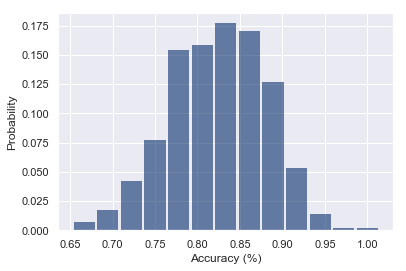

In [31]:
accs = GetAccuracyDist(x, y, model=LogisticRegression(solver='lbfgs'))
accs_df['Logistic'] = accs

The distribution of accuracies is roughly symmetrical with a mean and median of 83%. We tried improving logistic regression with PCR but the accuracy distribution remained the same. The work for that can be found [here](https://github.com/coverney/ThinkStats2/blob/master/project3/PCR.ipynb). 

### [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) 

k-Nearest Neighbors involves splitting the data into clusters by distance measures and using those clusters to predict the presence of heart disease for test patients.

Mean Accuracy: 0.75 | Median Accuracy: 0.75 | Max Accuracy: 0.92


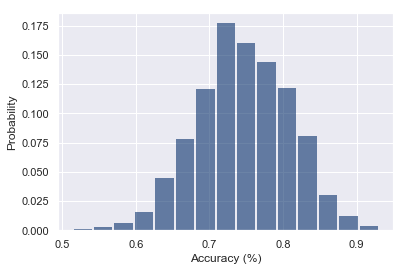

In [32]:
accs = GetAccuracyDist(x, y, KNeighborsClassifier(n_neighbors=3))
accs_df['KNN'] = accs

The distribution of accuracies is roughly symmetrical with a mean and median of 75%.

### [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

Classifier using Ridge regression, which penalizes for large coefficients using the L2 norm.

Mean Accuracy: 0.82 | Median Accuracy: 0.83 | Max Accuracy: 1.0


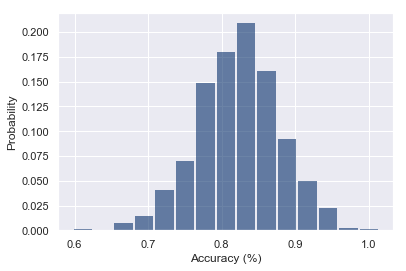

In [33]:
accs = GetAccuracyDist(x, y, RidgeClassifier(normalize=True))
accs_df['Ridge'] = accs

The distribution of accuracies is slightly skewed to the left with a median of 83%.

### [RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

According to `scikit-learn`, the random forest classifier is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

Mean Accuracy: 0.78 | Median Accuracy: 0.78 | Max Accuracy: 0.94


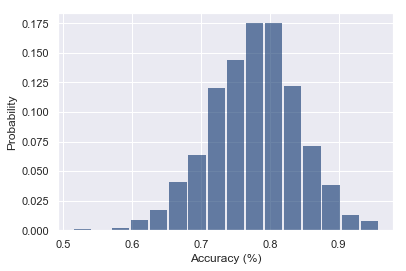

In [34]:
accs = GetAccuracyDist(x, y, RandomForestClassifier())
accs_df['Forest'] = accs

The distribution of accuracies is symmetrical with a mean and median of 78%.

### [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

The Lasso linear model penalizes for large coefficients using the L1 norm.

Mean Accuracy: 0.55 | Median Accuracy: 0.56 | Max Accuracy: 0.75


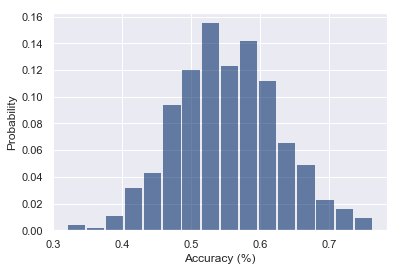

In [35]:
accs = GetAccuracyDist(x, y, Lasso())
accs_df['Lasso'] = accs

The distribution of accuracies is symmetrical with a median of 56%.

### [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

Elastic net is a form of penalized logistic regression. 

Mean Accuracy: 0.56 | Median Accuracy: 0.56 | Max Accuracy: 0.78


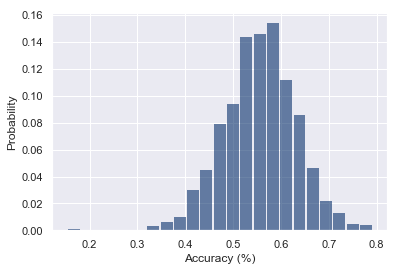

In [36]:
accs = GetAccuracyDist(x, y, ElasticNet())
accs_df['ElasticNet'] = accs

The distribution of accuracies is slightly skewed to the left with a median of 56%.

### [Neural Net](https://keras.io/layers/core/)

Using Keras as a high-level API for TensorFlow, we experiment with a simple neural network with 4 layers:
- First hidden layer using `relu` activation function consists of 17 neurons
- Second hidden layer using `relu` activation function consists of 21 neurons
- Third hidden layer using `relu` activation function consists of 25 neurons
- Final output layer using `softmax` activation function layer consists of 2 neurons to classify the two classes (heart disease present or not)

We also apply **L2 regularization (Ridge)** to each layer and use **early stopping** to address the over-fitting problem. We use `categorical_crossentropy` loss as a general loss function for any classification problems. Because our training data has only a dozen of features and 144 samples and the Adam optimizer tends to over-fit the model more quickly than Stochastic Gradient Descent (SGD), we choose SGD with the tuned learning rate of 0.008.

`plotAccuracyAndLoss` is a plotting function that plots the neural network's accuracy and loss against epoch, which stands for one iteration through the training data.

In [39]:
def plotAccuracyAndLoss(history):
    fig, ax = plt.subplots(1, 2, figsize=(14,4))
    #  "Accuracy"
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set(xlabel='Epoch', ylabel='Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].legend(['train', 'validation'], loc='upper left')
    # "Loss"
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set(xlabel='Epoch', ylabel='Loss')
    ax[1].set_title('Model Loss')
    ax[1].legend(['train', 'validation'], loc='upper left')
    plt.show()

We then run the model 50 times.

In [40]:
early_stopping_monitor = EarlyStopping(patience=2)
optim = optimizers.SGD(lr=0.008)

min_loss = np.inf
best_history = None
accs = []
for _ in range(50):
    model = Sequential()
    model.add(Dense(17, activation='relu', input_shape=(x.shape[1],), use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(21, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(25, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(2, activation='softmax', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x, to_categorical(y), shuffle=True, validation_split=0.20, epochs=500, callbacks = [early_stopping_monitor], verbose=False)
    accs.append(history.history['val_acc'][-1])
    if min_loss > history.history['val_loss'][-1]:
        min_loss = history.history['val_loss'][-1]
        best_history = history

KeyError: 'val_acc'

and plot the accuracies and losses of the best run.

In [ ]:
plotAccuracyAndLoss(best_history)

In the right figure, the loss of the validation set begins to diverge from the loss of the training set after epoch 100. After 150 epochs, the model starts overfitting the data. From the left figure, the final accuracy of the validation set is around 85%.    

In [ ]:
accs_df['NeuralNet'] = np.nan
accs_df['NeuralNet'][0:len(accs)] = accs
printAndPlotPmf(accs)

The distribution of accuracies is dispersed into three clusters. The two clusters with the lowest accuracies correspond to models that failed to train the network. In the biggest cluster, the accuracies peak at around 80%. The mean accuracy of the neural network is fairly low compared to other models, and the max accuracy is about the same as the mean accuracy of Logistic Regression, KNN and Ridge. The neural network model does not work as well as other simpler models even though it takes more time to tune and train the neural net.

We plot a boxplot to compare the performances of all of the models we tried. 

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(data=accs_df, palette="Set2", showfliers=False)
_ = ax.set(ylabel="Accuracy", title="Model Comparison")

Logistic regression and the Ridge classifier appear to have the highest median accuracies. KNN has a slightly lower median, 25th percentile, and 75th percentile than logistic regression and Ridge. Forest has the third highest median accuracy followed by KNN and the neural network. Elastic net and Lasso both have similar accuracy distributions and the lowest medians.  

Overall, we were able to run several models and get some pretty accurate results. We plan to contribute our analyses to the DrivenData competition. 

## Resources
- Aha, D., and Dennis Kibler. "Instance-based prediction of heart-disease presence with the Cleveland database." University of California 3.1 (1988): 3-2.